In [1]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.io
import os

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import functorch

import gc

import matplotlib.pyplot as plt

from cfollmer.evaluation_utils import ECE
import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost, stl_control_cost, vargrad_control_cost
from cfollmer.drifts import SimpleForwardNetBN, ScoreNetwork, ResNetScoreNetwork
from cfollmer.sampler_utils import FollmerSDE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class DNN(torch.nn.Module):

    def __init__(self, input_dim=1, output_dim=1):
        super(DNN, self).__init__()

        self.output_dim = output_dim
        self.input_dim = input_dim

        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.nn(x)

In [4]:
from sklearn.model_selection import train_test_split

mat = scipy.io.loadmat("../data/banana/benchmarks.mat")["banana"]

x = mat["x"][0, 0]
t = (mat["t"][0, 0][:, 0] + 1) // 2

x_train, x_test, y_train, y_test = train_test_split(x, t, test_size=0.1, random_state=2)


x_train, x_test, y_train, y_test = \
    torch.tensor(x_train, dtype=torch.float32, device=device), \
    torch.tensor(x_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.int64, device=device), \
    torch.tensor(y_test, dtype=torch.int64, device=device) 

train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

N_train = x_train.shape[0]
N_test = x_test.shape[0]

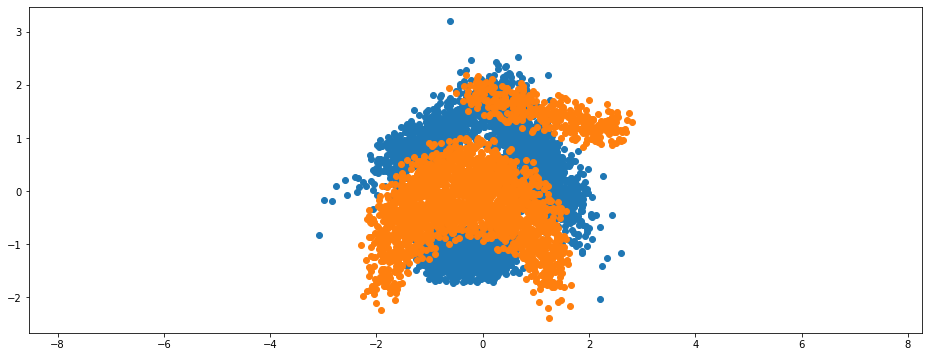

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
for i in range(2):
    X_plot = x[t == i]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=i)
ax1.axis('equal');

In [6]:
model = DNN(2, 2).to(device)
func_model, params = functorch.make_functional(model)
size_list = functional.params_to_size_tuples(params)
dim = functional.get_number_of_params(size_list)
  
sigma2 = 1.

def log_prior(params):
    return -torch.sum(params**2) / (2 * sigma2)

def log_likelihood(x, y, params):
    preds = func_model(functional.get_params_from_array(params, size_list), x)
    # return -F.binary_cross_entropy_with_logits(preds, y.unsqueeze(-1), reduction="sum")
    return -F.cross_entropy(preds, y, reduction="sum")

def log_likelihood_batch(x, y, params_batch):
    func = lambda params: log_likelihood(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

def log_posterior(x, y, params):
    return log_prior(params) + (N_train / x.shape[0]) * log_likelihood(x, y, params)

def log_posterior_batch(x, y, params_batch):
    func = lambda params: log_posterior(x, y, params)
    func = functorch.vmap(func)
    return func(params_batch)

/tmp/ipykernel_15978/1941700207.py:2: UserWarning: If this is your first time using make_functional, please ignore this warning. Otherwise, we recently made a backwards incompatible change to make_functional: please try make_functional_deprecated_v1 if you want the previous behavior.
  func_model, params = functorch.make_functional(model)


In [56]:
def train(gamma, n_epochs, data_batch_size, param_batch_size, dt=0.05, stl=False):
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    lr = 2e-5
    optimizer = torch.optim.Adam(sde.parameters(), lr=lr)
    
    dataloader_train = DataLoader(train_data, shuffle=True, batch_size=data_batch_size, num_workers=0)

    losses = []

    for _ in range(n_epochs):
        epoch_losses = []
        for x, y in tqdm(iter(dataloader_train)):
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
        
            partial_log_p = lambda params_batch: log_posterior_batch(x, y, params_batch)
            
            if stl:
                loss = vargrad_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
            else:
                loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
            loss.backward()

            epoch_losses.append(loss.detach().cpu().numpy())
            optimizer.step()
            
            if stl: # double check theres no references left
                sde.drift_network_detatched.load_state_dict((sde.drift_network.state_dict()))
            
        #  Memory leaks somewhere with sdeint / param_T = param_trajectory[-1]
        gc.collect()

        losses.append(epoch_losses)
    
    losses = np.array(losses)
    
    return sde, losses

In [57]:
gamma = 0.05**2
n_epochs = 50
data_batch_size = 512
param_batch_size = 32

num_exp = 5

weights_path = "../weights/banana/"
results_path = "../results/banana/"

if not os.path.exists(weights_path):
    os.makedirs(weights_path)
if not os.path.exists(results_path):
    os.makedirs(results_path)

In [58]:
for i in range(num_exp):
    sde, losses = train(gamma, n_epochs, data_batch_size, param_batch_size, dt=0.05, stl=False)
    torch.save(sde.state_dict(), f"{weights_path}weights-{i}.pt")
    del sde
    torch.cuda.empty_cache()

  0%|                                                                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]/home/dfernandes/anaconda3/envs/PYTORCH/lib/python3.9/site-packages/torch/nn/functional.py:2330: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-nsty933i/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.05it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.03it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.04it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.02it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.06it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


In [59]:
def evaluate(param_samples, train=False):
    if train:
        dataloader_test = DataLoader(train_data, shuffle=False, batch_size=data_batch_size, num_workers=0)
    else:
        dataloader_test = DataLoader(test_data, shuffle=False, batch_size=data_batch_size, num_workers=0)
    
    all_predictions = []
    all_confidences = []
    all_logps = []
    
    for x, y in tqdm(iter(dataloader_test)):
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            
            predict_func = lambda params : func_model(functional.get_params_from_array(params, size_list), x)
            predict_func = functorch.vmap(predict_func)

            out = F.softmax(predict_func(param_samples), dim=-1)
            out = torch.mean(out, dim=0)
            
            confidences, predictions = torch.max(out, dim=1)

            all_predictions.append(predictions)
            all_confidences.append(confidences)
            
            all_logps.append(torch.mean(log_likelihood_batch(x, y, param_samples)))
        del x
        del y
    
    all_predictions = torch.hstack(all_predictions).cpu().numpy()
    all_confidences = torch.hstack(all_confidences).cpu().numpy()
    true_labels = y_test.cpu().numpy()
    if train: 
        true_labels = y_train.cpu().numpy()
    else:
        true_labels = y_test.cpu().numpy()
    
    accuracy = np.mean(all_predictions == true_labels)
    ece = ECE(all_confidences, all_predictions, true_labels)
    
    logp = torch.sum(torch.stack(all_logps)) / N_test
    logp = logp.cpu().numpy()
    return accuracy, ece, logp

In [60]:
accuracies, eces, logps = [], [], []
accuracies_train, eces_train, logps_train = [], [], []


params_all = None
for i in range(num_exp):
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    sde.load_state_dict(torch.load(f"{weights_path}weights-{i}.pt"))
    with torch.no_grad():
        param_samples = sde.sample(100, dt=0.005, device=device)
    
    if params_all is None:
        params_all = param_samples.unsqueeze(0).cpu().numpy()
    else:
        params_all = np.concatenate((params_all, param_samples.unsqueeze(0).cpu().numpy()))

    accuracy, ece, logp = evaluate(param_samples)
    accuracy_train, ece_train, logp_train = evaluate(param_samples, train)

    accuracies.append(accuracy)
    eces.append(ece)
    logps.append(logp)
    accuracies_train.append(accuracy_train)
    eces_train.append(ece_train)
    logps_train.append(logp_train)
    del param_samples
    gc.collect()
    torch.cuda.empty_cache()
    
accuracies = np.array(accuracies)
eces = np.array(eces)
logps = np.array(logps)
accuracies_train = np.array(accuracies_train)
eces_train = np.array(eces_train)
logps_train = np.array(logps_train)

SBP_df = pd.DataFrame({"Accuracy": accuracies, "ECE": eces, "log predictive": logps})
SBP_train_df = pd.DataFrame({"Accuracy": accuracies_train, "ECE": eces_train, "log predictive": logps_train})

with open(f"{results_path}cfollmer_test.txt", "w") as f:
    f.write(str(SBP_df.describe()))
with open(f"{results_path}cfollmer_train.txt", "w") as f:
    f.write(str(SBP_train_df.describe()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 197.77it/s]


In [61]:
import matplotlib.colors as colors

def plt_contour(params, name, title):
    plt.clf()

    plt.plot(x_test[y_test==1, 0].cpu().numpy(), x_test[y_test==1, 1].cpu().numpy(), 'bx', alpha=0.6)
    plt.plot(x_test[y_test==0, 0].cpu().numpy(), x_test[y_test==0, 1].cpu().numpy(), 'ro', alpha=0.6)
    # plt.legend(('y=1', 'y=0'))


    # # Overlay contour plot of approximate predictive distribution:
    x_grid = np.arange(-3, 3, 0.05)
    X1, X2 = np.meshgrid(x_grid, x_grid)
    NG = X1.size
    X_test_2 = np.hstack((X1.reshape(NG,1), X2.reshape(NG,1)))
    X_test_2_tt = torch.tensor(X_test_2).to(device).float()

    predict_func = lambda params_lambda : func_model(functional.get_params_from_array(params_lambda, size_list), X_test_2_tt)
    predict_func = functorch.vmap(predict_func)
    
    p_test = None
    for i in range(params.shape[0]):
        out = F.softmax(predict_func(torch.tensor(params[i]).to(device)), dim=-1)
        out = torch.mean(out, dim=0)
        p_max, class_max = torch.max(out, dim=1)
        p_min, class_min = torch.min(out, dim=1)

        if p_test is None:
            p_test = (p_max * class_max + p_min * class_min).detach().cpu().numpy()
        else:
            p_test += (p_max * class_max + p_min * class_min).detach().cpu().numpy()
    p_test /= params.shape[0]

    P = np.reshape(p_test, X1.shape)
    CS = plt.contourf(X1, X2, P, cmap="bone", norm=colors.Normalize(vmin=-0.2))
                      #cmap=plt.cm.bone)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.colorbar()
    plt.title(title)
    plt.savefig(f"{results_path}{name}.pdf")

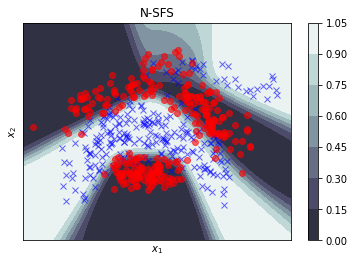

In [62]:
plt_contour(params_all, "banana_cfollmer", "N-SFS")

SGLD from here onwards

In [14]:
@torch.enable_grad()
def gradient(x, y, params):
    params_ = params.clone().requires_grad_(True)
    loss = log_posterior(x, y, params_)
    grad, = torch.autograd.grad(loss, params_)
    return loss.detach().cpu().numpy(), grad

In [25]:
lr = 2e-3
def step_size(n):
    return lr / (1 + n)**0.55

In [26]:
def sgld(n_epochs, data_batch_size):
    dataloader_train = DataLoader(train_data, shuffle=True, batch_size=data_batch_size, num_workers=0)
    model = DNN(2, 2).to(device)
    params = torch.cat([param.flatten() for param in model.parameters()]).detach()
    losses = []
    step = 0
    for _ in range(n_epochs):
        epoch_losses = []
        for x, y in tqdm(iter(dataloader_train)):
            x = x.to(device)
            y = y.to(device)

            eps = step_size(step)
            loss, grad = gradient(x, y, params)
            params = params + 0.5 * eps * grad #+ np.sqrt(eps) * torch.randn_like(params)
            step += 1
            epoch_losses.append(loss)
        
        losses.append(epoch_losses)
    
    param_samples = []
    
    iterator = iter(dataloader_train)
    for _ in range(100):
        x = x.to(device)
        y = y.to(device)
        
        eps = step_size(step)
        loss, grad = gradient(x, y, params)
        params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
        param_samples.append(params)
        step += 1
        
    param_samples = torch.stack(param_samples)
    losses = np.array(losses)
    
    return param_samples, losses

In [27]:
accuracies, eces, logps = [], [], []
accuracies_train, eces_train, logps_train = [], [], []

params_all = None
for i in range(num_exp):
    param_samples, losses = sgld(n_epochs, data_batch_size)
    if params_all is None:
        params_all = param_samples.unsqueeze(0).cpu().numpy()
    else:
        params_all = np.concatenate((params_all, param_samples.unsqueeze(0).cpu().numpy()))

    accuracy, ece, logp = evaluate(param_samples)
    accuracy_train, ece_train, logp_train = evaluate(param_samples, train)

    accuracies.append(accuracy)
    eces.append(ece)
    logps.append(logp)
    accuracies_train.append(accuracy_train)
    eces_train.append(ece_train)
    logps_train.append(logp_train)
    del param_samples
    gc.collect()
    torch.cuda.empty_cache()
    
accuracies = np.array(accuracies)
eces = np.array(eces)
logps = np.array(logps)
accuracies_train = np.array(accuracies_train)
eces_train = np.array(eces_train)
logps_train = np.array(logps_train)

SGLD_df = pd.DataFrame({"Accuracy": accuracies, "ECE": eces, "log predictive": logps})
SGLD_train_df = pd.DataFrame({"Accuracy": accuracies_train, "ECE": eces_train, "log predictive": logps_train})

with open(f"{results_path}sgld_test.txt", "w") as f:
    f.write(str(SGLD_df.describe()))
with open(f"{results_path}sgld_train.txt", "w") as f:
    f.write(str(SGLD_train_df.describe()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 177.36it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 207.76it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 218.72it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 193.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 213.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 215.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 222.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 181.79it/s]


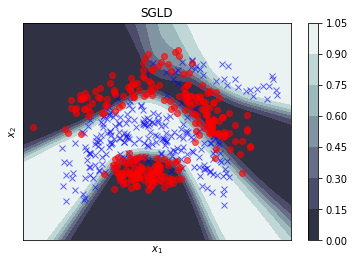

In [28]:
plt_contour(params_all, "banana_sgld", "SGLD")

In [35]:
def sgd(n_epochs, data_batch_size):
    
    lr = 1e-1
    dataloader_train = DataLoader(train_data, shuffle=True, batch_size=data_batch_size, num_workers=0)
    model = DNN(2, 2).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []

    for i in range(n_epochs):
        for x, y in tqdm(iter(dataloader_train)):

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            out = model(x)

            l = F.cross_entropy(out, y, reduction="mean")

            l.backward()

            losses.append(l.detach().cpu().numpy())

            optimizer.step()

    losses = np.array(losses)
    
    return model, losses

In [36]:
accuracies, eces, logps = [], [], []
accuracies_train, eces_train, logps_train = [], [], []

params_all = None
for i in range(num_exp):
    model, losses = sgd(n_epochs, data_batch_size)
    params = model.parameters()
    params = torch.cat([param.flatten() for param in params]).detach()
    params = params.view(1, -1)
    if params_all is None:
        params_all = params.unsqueeze(0).cpu().numpy()
    else:
        params_all = np.concatenate((params_all, params.unsqueeze(0).cpu().numpy()))
    accuracy, ece, logp = evaluate(params)
    accuracy_train, ece_train, logp_train = evaluate(params, train)

    accuracies.append(accuracy)
    eces.append(ece)
    logps.append(logp)
    accuracies_train.append(accuracy_train)
    eces_train.append(ece_train)
    logps_train.append(logp_train)
    del params
    gc.collect()
    torch.cuda.empty_cache()
    
accuracies = np.array(accuracies)
eces = np.array(eces)
logps = np.array(logps)
accuracies_train = np.array(accuracies_train)
eces_train = np.array(eces_train)
logps_train = np.array(logps_train)

SGD_df = pd.DataFrame({"Accuracy": accuracies, "ECE": eces, "log predictive": logps})
SGD_train_df = pd.DataFrame({"Accuracy": accuracies_train, "ECE": eces_train, "log predictive": logps_train})

with open(f"{results_path}sgd_test.txt", "w") as f:
    f.write(str(SGD_df.describe()))
with open(f"{results_path}sgd_train.txt", "w") as f:
    f.write(str(SGD_train_df.describe()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 228.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 209.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 225.54it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 233.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 249.32it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 259.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 202.08it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 164.58it/s]


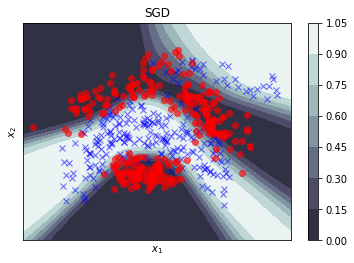

In [37]:
plt_contour(params_all, "banana_sgd", "SGD")